Case 0:
  Continuous Solution - Value: -1.21633, Penalty: -0.00001, Score: -1.21632
  Exact Solution - Value: -1.21633, Penalty: 0.00000, Score: -1.21633
  Qaoa Solution - Value: -1.21633, Penalty: 0.00000, Score: -1.21633

Case 1:
  Continuous Solution - Value: -25.05057, Penalty: 0.00000, Score: -25.05057
  Exact Solution - Value: -25.05057, Penalty: 0.00000, Score: -25.05057
  Qaoa Solution - Value: -25.05057, Penalty: 0.00000, Score: -25.05057

Case 2:
  Continuous Solution - Value: -3.97951, Penalty: 2.82544, Score: -6.80495
  Exact Solution - Value: -3.97951, Penalty: 2825.43945, Score: -2829.41897
  Qaoa Solution - Value: -3.97951, Penalty: 2825.43945, Score: -2829.41897

Case 3:
  Continuous Solution - Value: -4.59400, Penalty: 0.38106, Score: -4.97507
  Exact Solution - Value: -4.59400, Penalty: 381.06537, Score: -385.65937
  Qaoa Solution - Value: -4.59400, Penalty: 381.06537, Score: -385.65937

Case 4:
  Continuous Solution - Value: -2.14464, Penalty: 0.73096, Score: -2.8756

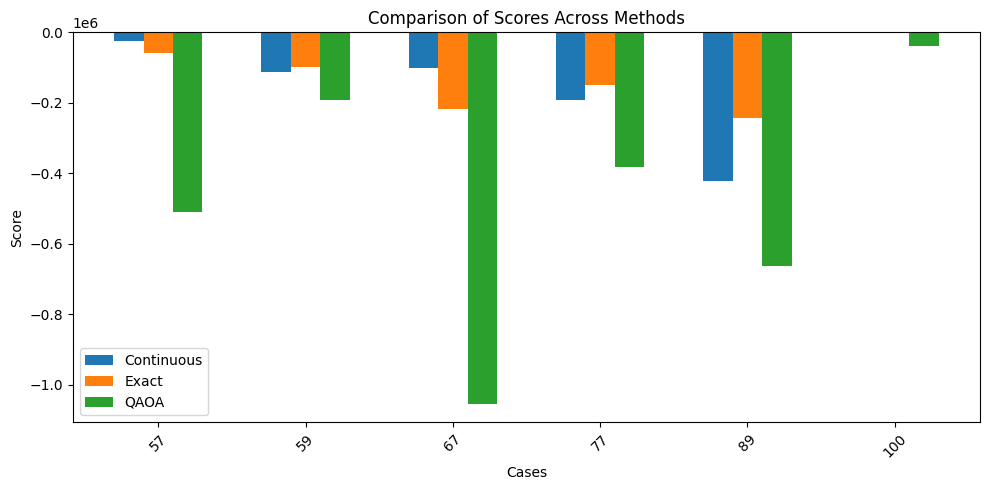

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    

def compare_solutions(data):
    results = {}
    
    for case_id, case_data in data.items():
        cont_sol = case_data.get("continuous_variables_solution", {})
        exact_sol = case_data.get("exact_solution", {})
        qaoa_sol = case_data.get("qaoa_solution", {})
        budget = case_data["hyperparams"]["budget"]
        penalizer = 1000
        
        cont_value = cont_sol.get("value", 0)
        cont_penalty = cont_sol.get("left_overs", 0)
        
        exact_budgets = exact_sol.get("result_with_budget", [])[0]
        exact_value = exact_budgets.get("objective_value", 0)
        exact_penalty = penalizer*abs(exact_budgets["difference"])
        
        qaoa_value = qaoa_sol.get("objective_values", [])[-1]
        qaoa_budgets = qaoa_sol.get("result_with_budget", [])[-1]
        qaoa_penalty = penalizer*abs(qaoa_budgets["difference"])

        results[case_id] = {
            "continuous": {"value": cont_value, "penalty": cont_penalty, "score": cont_value - cont_penalty},
            "exact": {"value": exact_value, "penalty": exact_penalty, "score": exact_value - exact_penalty},
            "qaoa": {"value": qaoa_value, "penalty": qaoa_penalty, "score": qaoa_value - qaoa_penalty}
        }
    
    return results

def plot_scores(results):
    cases = list(results.keys())
    continuous_scores = [results[case]["continuous"]["score"] for case in cases]
    exact_scores = [results[case]["exact"]["score"] for case in cases]
    qaoa_scores = [results[case]["qaoa"]["score"] for case in cases]
    
    x = np.arange(len(cases))
    width = 0.2
    
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, continuous_scores, width, label="Continuous")
    plt.bar(x, exact_scores, width, label="Exact")
    plt.bar(x + width, qaoa_scores, width, label="QAOA")
    
    plt.xlabel("Cases")
    plt.ylabel("Score")
    plt.title("Comparison of Scores Across Methods")
    plt.xticks(ticks=x, labels=cases, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    file_path = "portfolio_optimization_results.json"  # Update with actual path
    data = load_json(file_path)
    results = compare_solutions(data)
    
    for case, comparison in results.items():
        print(f"Case {case}:")
        for method, values in comparison.items():
            print(f"  {method.capitalize()} Solution - Value: {values['value']:.5f}, Penalty: {values['penalty']:.5f}, Score: {values['score']:.5f}")
        print()
    
    subset_of_results = {}
    for key in list(results.keys()):
        assets_to_qubits = data[key]["hyperparams"]["assets_to_qubits"]
        n_qubits = sum([len(v) for v in assets_to_qubits.values()])
        if n_qubits == 8:
            subset_of_results[key] = results[key]
    
    plot_scores(subset_of_results)

main()

In [7]:
file_path = "experiments_data.json"
data = load_json(file_path)["data"]
print(json.dumps(data[80], indent=4))


{
    "max_qubits": 10,
    "budget": 3460.8899574279785,
    "stock_metadata": {
        "DOW": {
            "max_int": 7,
            "qubits": 3,
            "random_int": 3,
            "price": 40.130001068115234
        },
        "DIS": {
            "max_int": 127,
            "qubits": 7,
            "random_int": 30,
            "price": 111.3499984741211
        }
    },
    "stocks": [
        "DOW",
        "DIS"
    ],
    "start": "2015-01-01",
    "end": "2025-01-01",
    "n_stocks": 2
}


In [3]:
file_path = "portfolio_optimization_results.json"  # Update with actual path
data = load_json(file_path)
print(json.dumps(data["80"], indent=4))

{
    "hyperparams": {
        "stocks": [
            "DIS",
            "DOW"
        ],
        "start": "2015-01-01",
        "end": "2025-01-01",
        "risk_aversion": 3,
        "max_qubits": 15,
        "budget": 3460.8899574279785,
        "log_encoding": true,
        "layers": 5,
        "prices_now": {
            "DIS": 111.3499984741211,
            "DOW": 39.3990364074707
        },
        "assets_to_qubits": {
            "DIS": [
                0,
                1,
                2,
                3,
                4
            ],
            "DOW": [
                5,
                6,
                7,
                8,
                9,
                10
            ]
        }
    },
    "continuous_variables_solution": {
        "weights": {
            "DIS": 0.658883110430367,
            "DOW": 0.34111688956963304
        },
        "allocation": {
            "DIS": 20,
            "DOW": 30
        },
        "value": -3755366.0853934074,
     